<a href="https://colab.research.google.com/github/vienskaz/ECG-CNN/blob/GAN/EKG_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils import to_categorical
from scipy.signal import butter,filtfilt
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
from tensorflow import keras

In [2]:
mit_test_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_test.csv', header=None)
mit_train_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_train.csv', header=None)

X_train = mit_train_data.iloc[:, :-1].values
y_train = mit_train_data.iloc[:, -1].values
X_test = mit_test_data.iloc[:, :-1].values
y_test = mit_test_data.iloc[:, -1].values

normal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_normal.csv', header=None)
abnormal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_abnormal.csv', header=None)
X_normal = normal.iloc[:, :-1].values
y_normal = np.zeros(X_normal.shape[0])
X_abnormal = abnormal.iloc[:, :-1].values
y_abnormal = np.ones(X_abnormal.shape[0])

X = np.concatenate([X_normal, X_abnormal], axis=0)
y = np.concatenate([y_normal, y_abnormal], axis=0)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X = X.reshape((X.shape[0], X.shape[1], 1))

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [3]:
def moving_average_filter(signal, window_size=5):
    filtered=[]
    for data in signal:
      filtered_ecg = np.convolve(data.flatten(), np.ones(window_size) / window_size, mode='same')
      filtered.append(filtered_ecg)
    return np.array(filtered)


In [4]:
two = []
three = []
four = []
five = []

for i in range(len(Y_train)):
    if np.array_equal(Y_train[i], [0.0, 1.0, 0.0, 0.0, 0.0]):
        two.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 1.0, 0.0, 0.0]):
        three.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 1.0, 0.0]):
        four.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 0.0, 1.0]):
        five.append(X_train[i])




In [5]:
np.array(two)
np.array(three)
np.array(four )
np.array(five )

array([[[0.71260995],
        [0.62903225],
        [0.52785921],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [0.4848485 ],
        [0.54166669],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.58404559],
        [0.5       ],
        [0.42450142],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.90612245],
        [0.62448978],
        [0.59591836],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.85822785],
        [0.64556962],
        [0.84556961],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.90150636],
        [0.84588647],
        [0.80069524],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [6]:
print(len(two))
print(len(three))
print(len(four))
print(len(five))

2223
5788
641
6431


In [7]:
two = moving_average_filter(two)
three = moving_average_filter(three)
four = moving_average_filter(four)
five = moving_average_filter(five)

In [8]:
print(two[0].shape)

(187,)


In [9]:
def build_discriminator(n=187):
    inps = layers.Input(shape=(n,))
    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(inps)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    outs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inps, outs, name='discriminator')
    return model

# Definicja generatora
def build_generator(latent_dim=50, output_shape=(187, 1)):
    inps = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(inps)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    outs = layers.Dense(output_shape[0] * output_shape[1], activation='relu')(x)
    outs = layers.Reshape(output_shape)(outs)  # Zmień kształt wyjścia
    model = models.Model(inps, outs, name='generator')
    return model
discriminator = build_discriminator()
generator = build_generator(latent_dim=50)
print(discriminator.summary(), generator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187)]             0         
                                                                 
 dense (Dense)               (None, 128)               24064     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57345 (224.00 KB)
Trainable params: 57345 (224.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

In [10]:
class GAN(keras.Model):

    def __init__(self, disc, gen, latent_dim=50):
        super(GAN, self).__init__()
        self.discriminator = disc
        self.generator = gen
        self.latent_dim = latent_dim

    def compile(self, optD, optG, loss_fn):
        super(GAN, self).compile()
        self.optD = optD
        self.optG = optG
        self.loss_fn = loss_fn

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        bs = tf.shape(real_data)[0]
        z = tf.random.normal(shape=(bs, self.latent_dim))
        fake_data = self.generator(z)
        fake_data = tf.squeeze(fake_data, axis=-1)  # Usuń zbędny wymiar, aby uzyskać kształt (batch_size, 187)
        combined_data = tf.concat([real_data, fake_data], axis=0)
        labels = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)

        with tf.GradientTape() as tape:
            preds = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, preds)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.optD.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        misleading_labels = tf.ones((bs, 1))
        z = tf.random.normal(shape=(bs, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_preds = self.discriminator(self.generator(z))
            g_loss = self.loss_fn(misleading_labels, fake_preds)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.optG.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

gan = GAN(discriminator, generator)

gan.compile(
    keras.optimizers.Adam(),
    keras.optimizers.Adam(),
    keras.losses.BinaryCrossentropy(from_logits=True)
)


In [11]:
def show_samples(epoch, generator, data, n=187, l_dim=50):
  # save results after every 20 epochs
  if epoch % 20 == 0:
    z = tf.random.normal(shape=(n, l_dim))
    generated_data = generator(z)
    generated_points_list.append(generated_data)

# list for storing generated points
generated_points_list = []
# a lambda callback
cbk = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: show_samples(epoch, gan.generator, two))


Epoch 1/5000


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
70/70 [==============================] - 1s 9ms/step - d_loss: 0.1926 - g_loss: 3.5746
Epoch 2502/5000
70/70 [==============================] - 1s 9ms/step - d_loss: 0.1894 - g_loss: 3.8048
Epoch 2503/5000
70/70 [==============================] - 1s 9ms/step - d_loss: 0.2022 - g_loss: 3.6513
Epoch 2504/5000
70/70 [==============================] - 1s 10ms/step - d_loss: 0.2159 - g_loss: 3.5946
Epoch 2505/5000
70/70 [==============================] - 1s 10ms/step - d_loss: 0.1966 - g_loss: 3.2247
Epoch 2506/5000
70/70 [==============================] - 1s 10ms/step - d_loss: 0.2149 - g_loss: 3.1944
Epoch 2507/5000
70/70 [==============================] - 1s 12ms/step - d_loss: 0.1895 - g_loss: 3.5946
Epoch 2508/5000
70/70 [==============================] - 1s 11ms/step - d_loss: 0.1881 - g_loss: 3.2817
Epoch 2509/5000
70/70 [==============================] - 1s 10ms/step - d_loss: 0.1770 - g_loss: 3.0449
Epoch 2510/5000
70

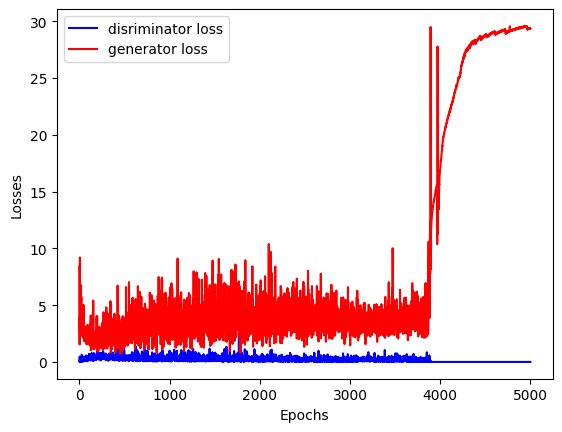

In [12]:
hist = gan.fit(two, epochs=5000, callbacks=[cbk], verbose=True)
'''
this will almost take 40-50 seconds but you can turn on the verbose and see progress along the way
'''

# plot the results
plt.plot(hist.history['d_loss'], color='blue', label='disriminator loss')
plt.plot(hist.history['g_loss'], color='red', label='generator loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

WAGI DLA 2

In [13]:
#gan.save_weights('/content/drive/MyDrive/ecg/two5000epok')

In [32]:
gan.load_weights('/content/drive/MyDrive/ecg/two')

In [33]:
def do_data(nums):
    result = []
    latent_dim = 50
    num_samples_to_generate = 1

    for i in range(nums):
        # Generuj nowy zestaw szumów dla każdej iteracji
        latent_points = tf.random.normal(shape=(num_samples_to_generate, latent_dim))

        # Użyj wytrenowanego generatora do wygenerowania danych
        generated_data = generator(latent_points)

        # Usuń zbędny pierwszy i trzeci wymiar, pozostawiając (187, 1)
        generated_data = tf.squeeze(generated_data, axis=[0, 2])

        # Dodaj wygenerowane dane do wynikowej listy
        result.append(generated_data)

    # Zamień listę na tablicę numpy
    return np.array(result)


In [34]:
twos=do_data(20)
print(twos.shape)
print(twos[0].shape)
print(two.shape)
print(two[0].shape)


(20, 187)
(187,)
(2223, 187)
(187,)


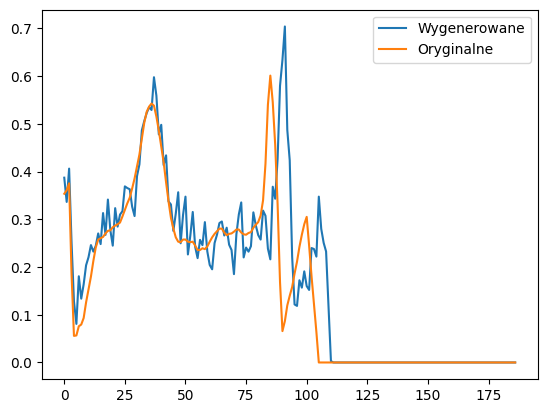

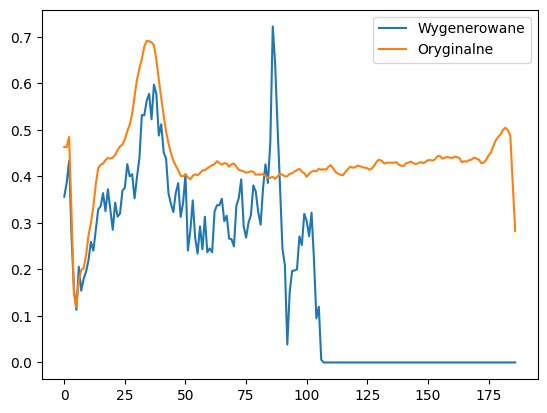

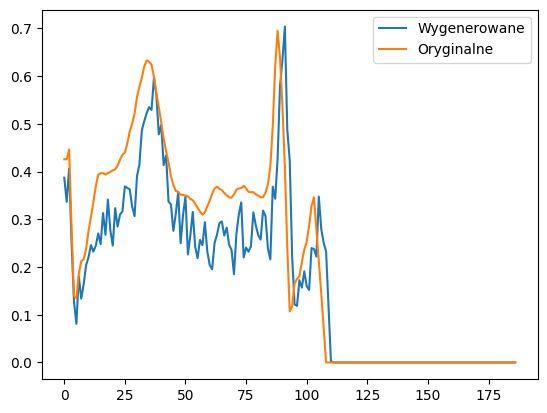

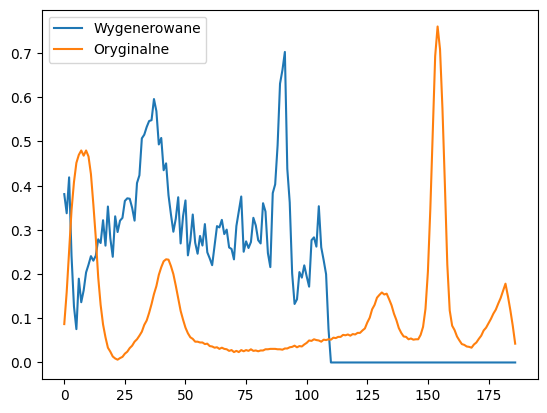

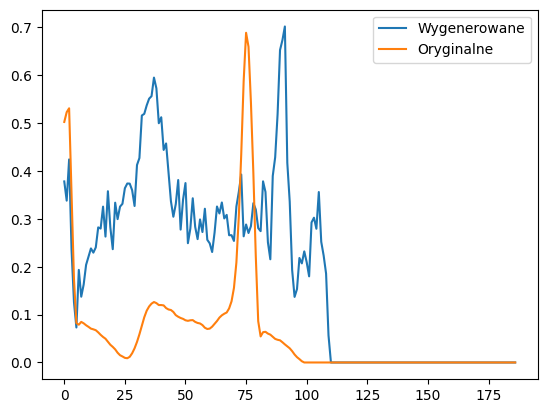

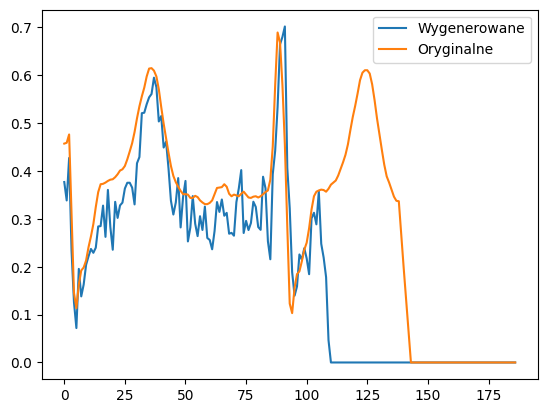

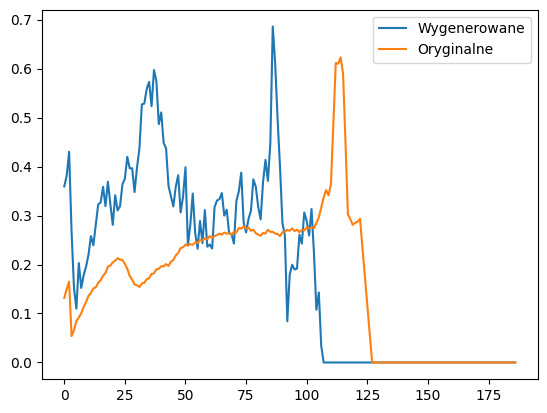

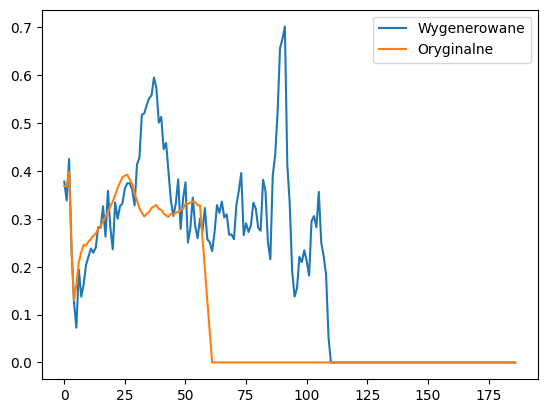

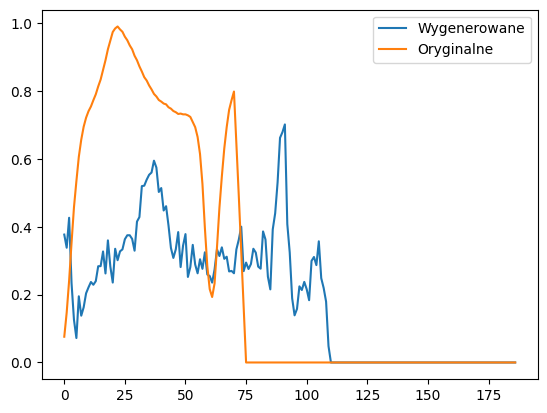

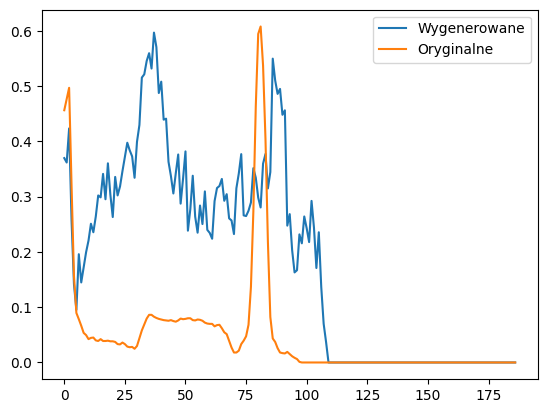

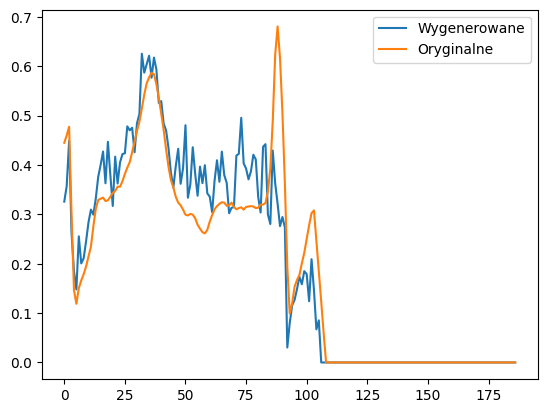

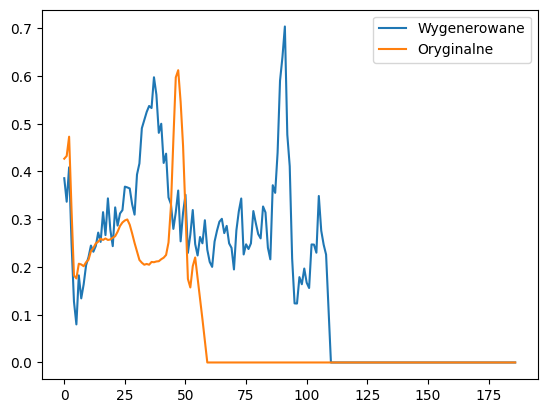

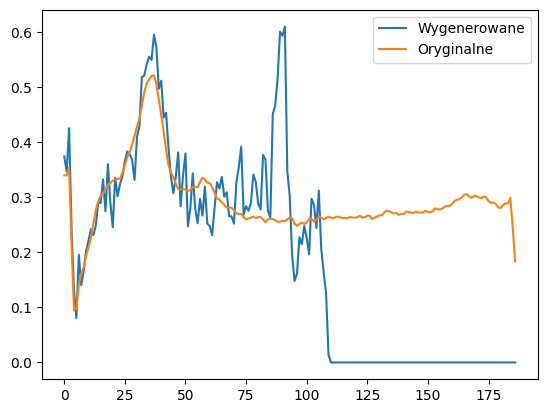

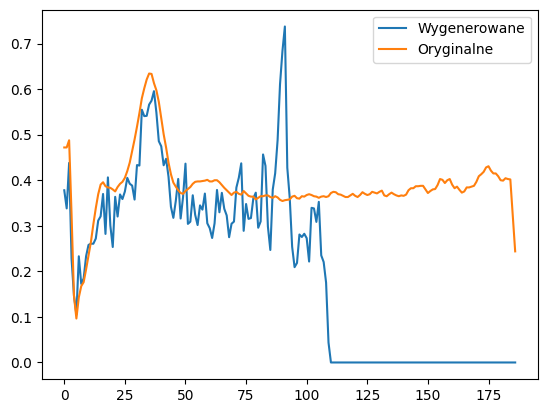

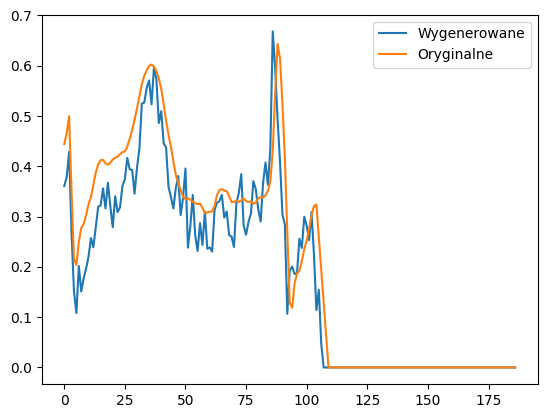

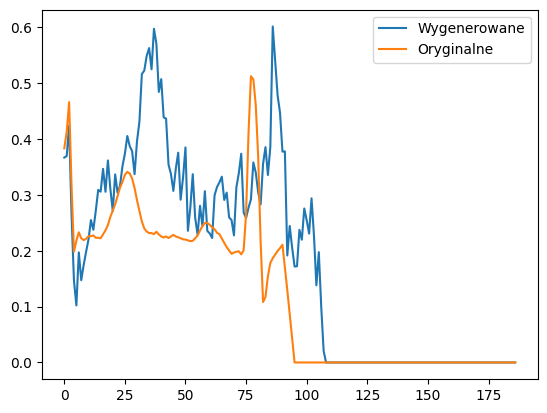

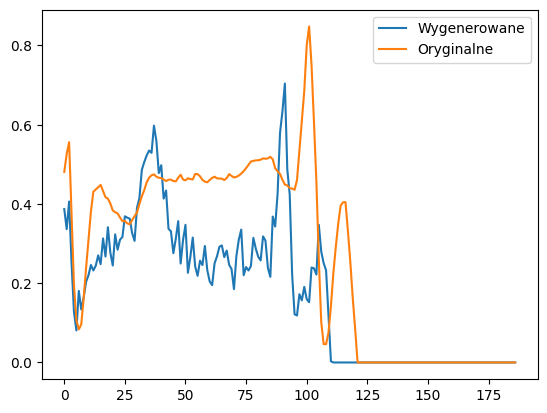

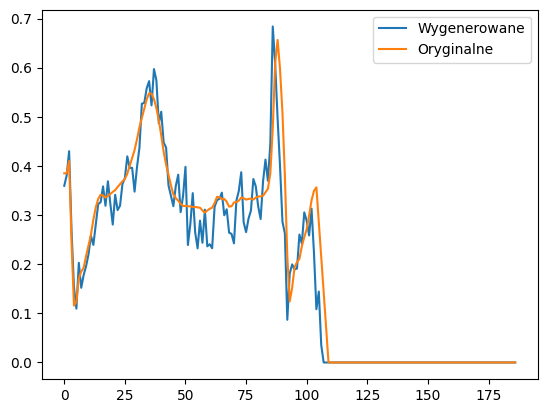

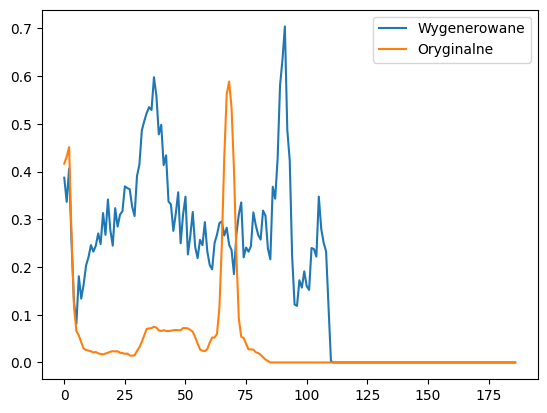

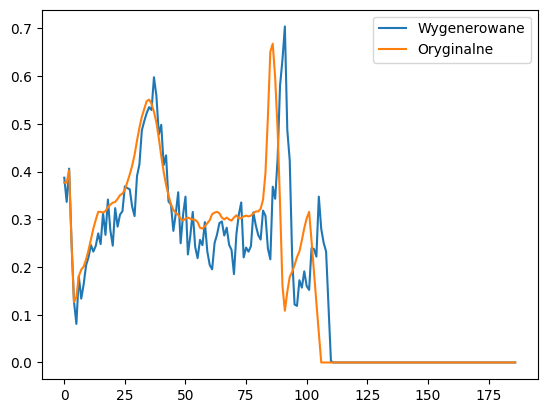

In [35]:
for i in range(len(twos)):
    plt.figure()
    plt.plot(twos[i], label='Wygenerowane')
    plt.plot(two[i], label='Oryginalne')

    # Dodanie legendy do wykresu
    plt.legend()

    # Wyświetlenie wykresu
    plt.show()

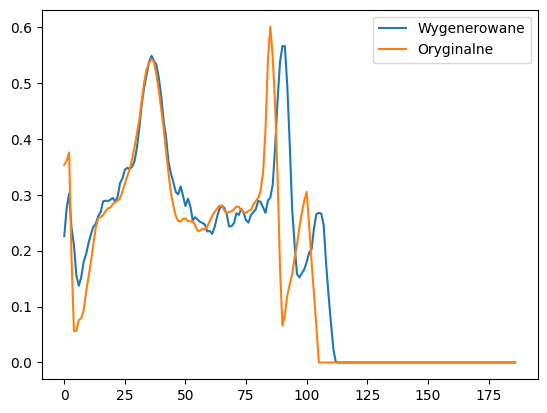

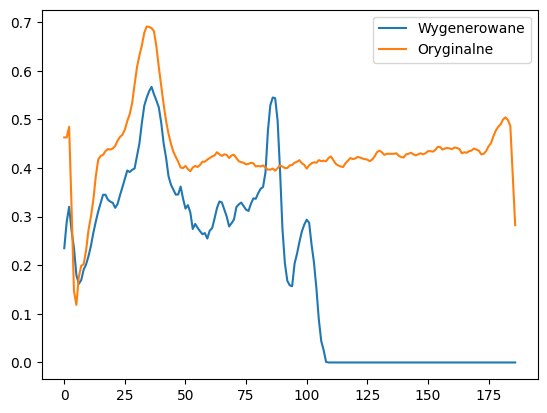

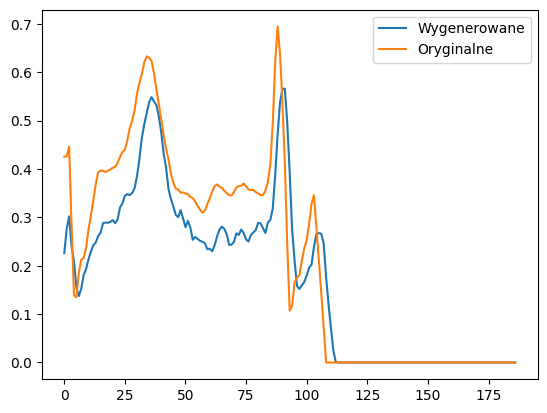

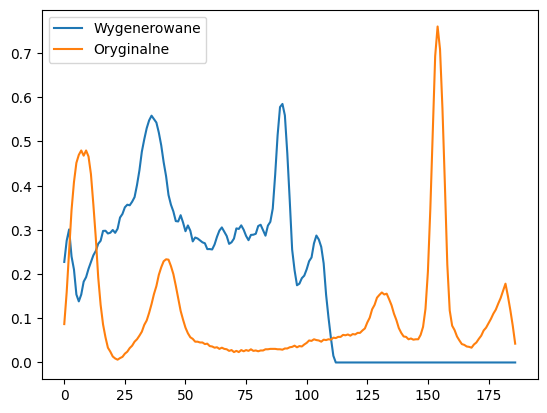

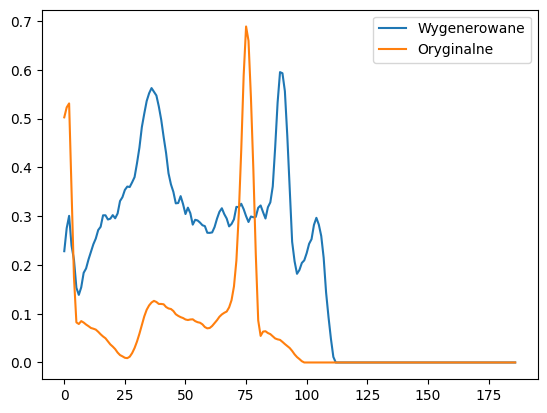

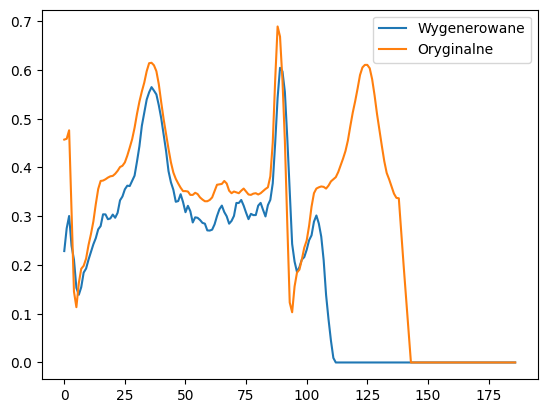

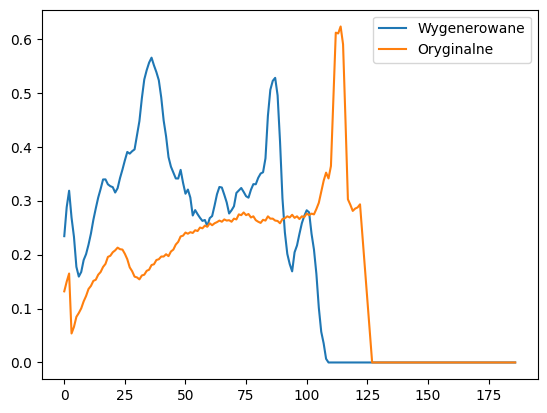

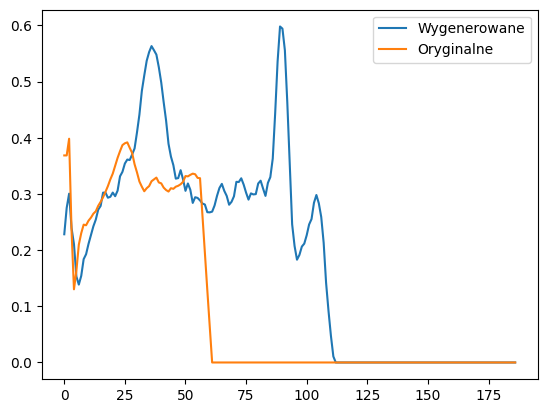

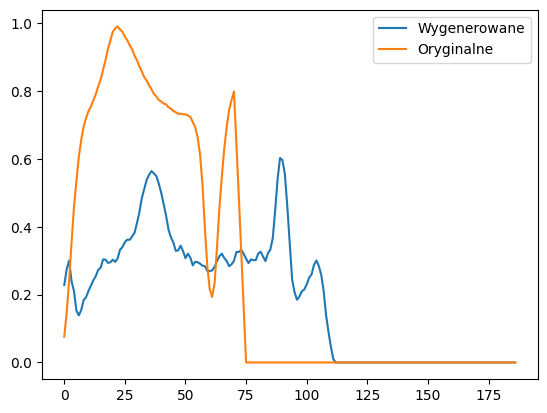

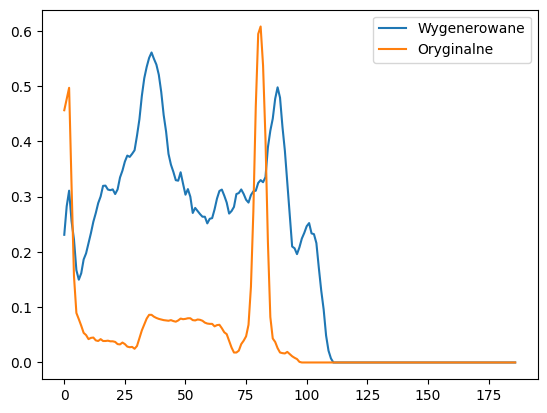

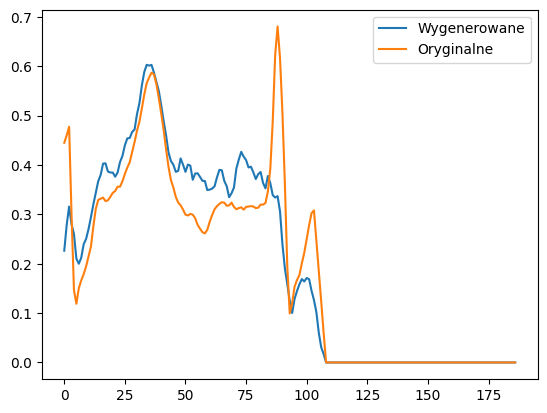

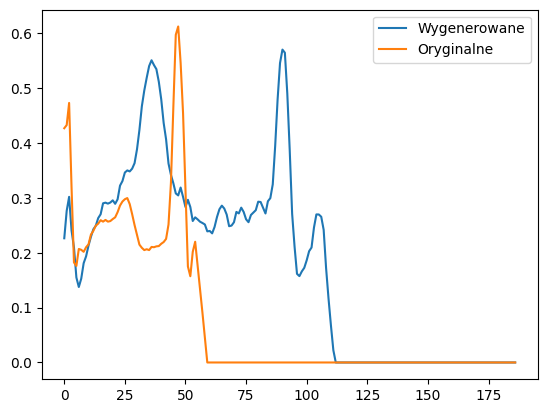

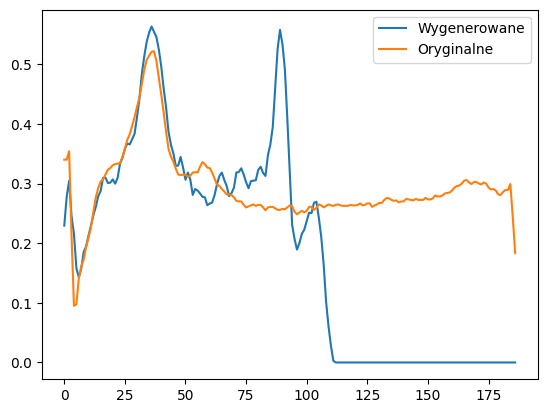

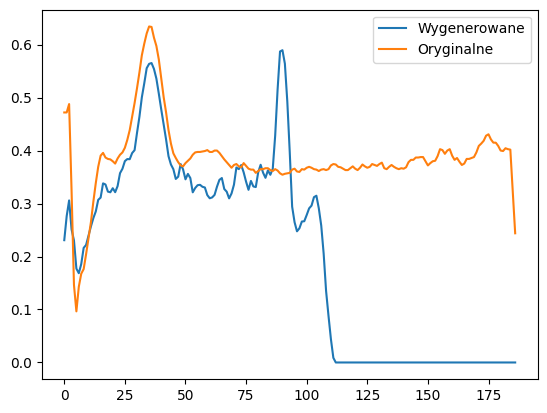

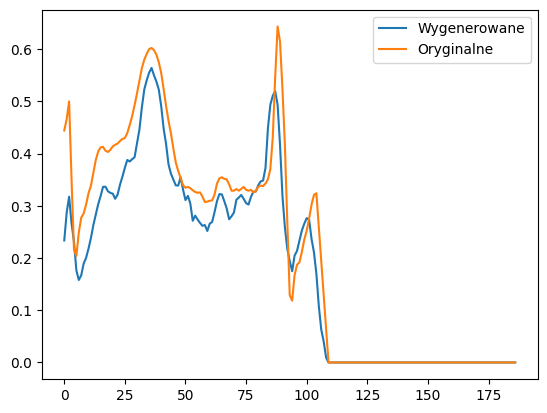

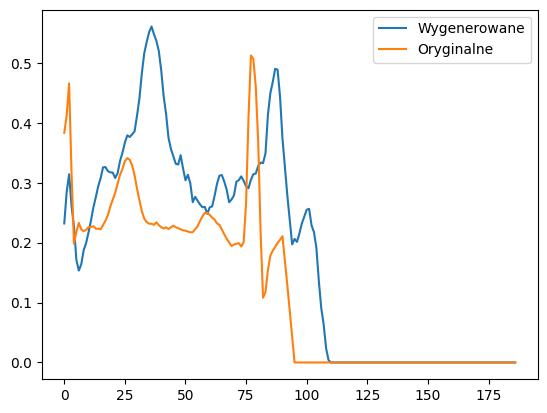

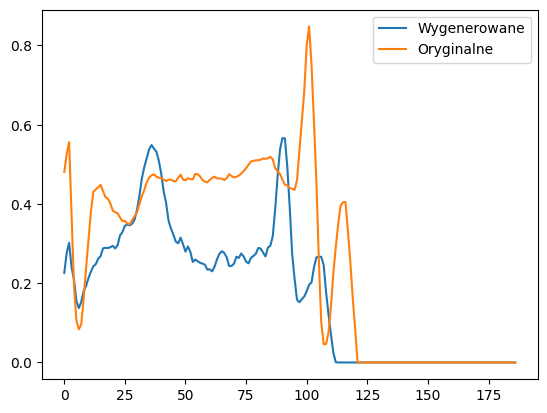

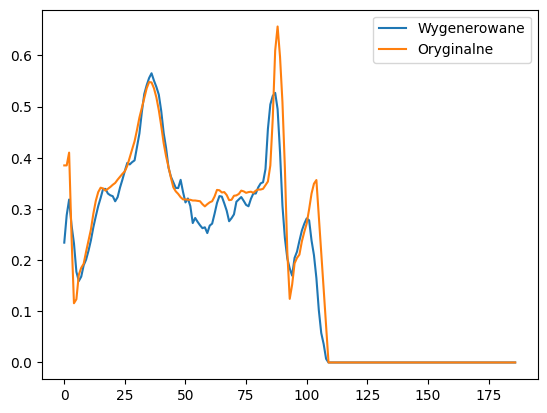

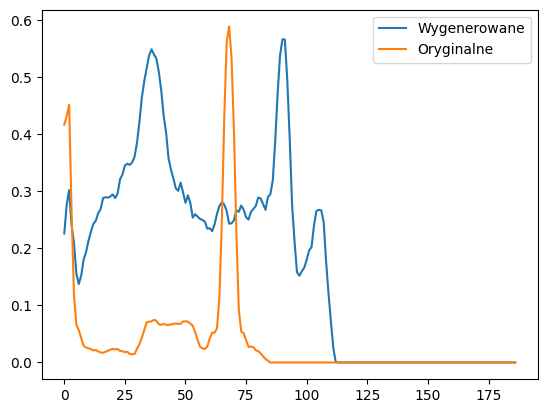

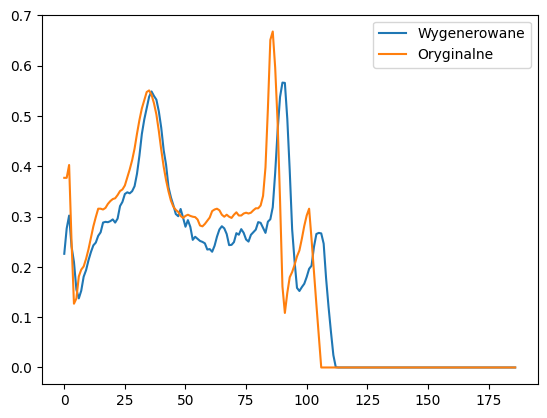

In [36]:
twos=moving_average_filter(twos)

for i in range(len(twos)):
    plt.figure()
    plt.plot(twos[i], label='Wygenerowane')
    plt.plot(two[i], label='Oryginalne')

    # Dodanie legendy do wykresu
    plt.legend()

    # Wyświetlenie wykresu
    plt.show()